In [1]:
!pip -q install optax

     |████████████████████████████████| 140 kB 7.7 MB/s 
     |████████████████████████████████| 72 kB 339 kB/s 


In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

%config InlineBackend.figure_format='retina'

In [3]:
! git init .
! git remote add origin https://github.com/VLSF/SNO
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 36 (delta 18), reused 32 (delta 17), pack-reused 0
Unpacking objects: 100% (36/36), done.
From https://github.com/VLSF/SNO
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [4]:
from functions import Fourier

# Introduction

In this notebook we explain and test functions from module `Fourier.py`.

This module provide basic functionality for periodic functions defined on $[-1, 1)$.

# Uniform grid



Just a uniform grid with `n` points on the interval `[-1, 1)`. Since function is periodic, right end is excluded.

In [5]:
Fourier.Uniform_grid(5)

DeviceArray([-1. , -0.6, -0.2,  0.2,  0.6], dtype=float64)

In [6]:
Fourier.Uniform_grid(10)

DeviceArray([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8],            dtype=float64)

# Get frequencies

Return frequencies that aligned with output of FFT for real signal.

In [7]:
Fourier.get_frequencies(5, is_real=False)

DeviceArray([ 0.+0.j        ,  0.+3.14159265j,  0.+6.28318531j,
             -0.-6.28318531j, -0.-3.14159265j], dtype=complex128)

In [8]:
Fourier.get_frequencies(5, is_real=True)

DeviceArray([0. +0.j        , 0. +3.14159265j, 0. +6.28318531j,
             0. +9.42477796j, 0.+12.56637061j],            dtype=complex128, weak_type=True)

# Align frequencies

This is how frequencies are ordered after FFT:

In [9]:
w = jnp.fft.fftfreq(10).reshape((-1, 1, 1))
w[:, 0, 0]

DeviceArray([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1],            dtype=float64)

And this is how they are reordered by the function:

In [10]:
Fourier.align_frequencies(w)[:, 0, 0]

DeviceArray([ 0. ,  0.1, -0.1,  0.2, -0.2,  0.3, -0.3,  0.4, -0.4, -0.5],            dtype=float64)

That is, in the order of increasing absolute value of frequency.

Last two axis are untouched:

In [11]:
Fourier.align_frequencies(w.reshape((1, 1, -1)))[0, 0, :]

DeviceArray([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1],            dtype=float64)

In [12]:
Fourier.align_frequencies(w.reshape((1, -1, 1)))[0, :, 0]

DeviceArray([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1],            dtype=float64)

Testing inverse transformation:

In [13]:
x = random.normal(random.PRNGKey(21), (25, 33, 12, 14))
y = jnp.fft.rfftn(x, axes=[i for i in range(len(x.shape)-1)])

p = Fourier.align_frequencies(Fourier.align_frequencies(y), forward=False)
jnp.linalg.norm((y - p).reshape(-1,), ord=jnp.inf)

DeviceArray(0., dtype=float64)

Check that the shape is correct

In [14]:
x = random.normal(random.PRNGKey(21), (25, 33, 12, 14))
Fourier.align_frequencies(x).shape

(25, 33, 12, 14)

# Values to coefficients / coefficients to values

FFT for real signal + reordering.

Testing inverse transformation:

In [15]:
x = random.normal(random.PRNGKey(21), (25, 33, 16, 13))
y = Fourier.values_to_coefficients(x)

p = Fourier.coefficients_to_values(y, x.shape)
jnp.linalg.norm((x - p).reshape(-1,), ord=jnp.inf)

DeviceArray(1.99840144e-15, dtype=float64)

In [16]:
Fourier.values_to_coefficients(Fourier.coefficients_to_values(y, [n if i != 2 else 2*n for i, n in enumerate(y.shape)])).shape

(25, 33, 10, 13)

In [17]:
x = random.normal(random.PRNGKey(21), (25, 33, 16, 13))
y = Fourier.values_to_coefficients(x)
y.shape

(25, 33, 9, 13)

Test that coefficients are correct for analytic case.

FFT

In [18]:
ord = 5
n_cos = ord // 2 + 1 if ord % 2 != 0 else ord // 2
n_sin = ord - n_cos
coeff = random.normal(random.PRNGKey(13), shape=(ord,))
f = lambda x: jnp.dot(jnp.vstack([jnp.cos(jnp.pi*i*x) for i in range(n_cos)] + [jnp.sin(jnp.pi*i*x) for i in range(1, n_sin+1)]).T, coeff)
values = f(Fourier.Uniform_grid(10))
known_coeff = jnp.array([coeff[0], coeff[1]/2 + coeff[3]/(2*1j), coeff[1]/2 - coeff[3]/(2*1j), coeff[2]/(2) + coeff[4]/(2*1j), coeff[2]/(2) - coeff[4]/(2*1j)])
print(Fourier.values_to_coefficients(values.reshape(-1, 1, 1)).reshape(-1,)[:len(known_coeff)] - known_coeff)

[4.44089210e-16+0.00000000e+00j 1.32706346e-16-3.74700271e-16j
 1.30104261e-16+3.74700271e-16j 0.00000000e+00-4.57966998e-16j
 0.00000000e+00+4.57966998e-16j]


In [19]:
ord = 4
n_cos = ord // 2 + 1 if ord % 2 != 0 else ord // 2
n_sin = ord - n_cos
coeff = random.normal(random.PRNGKey(15), shape=(ord,))
f = lambda x: jnp.dot(jnp.vstack([jnp.cos(jnp.pi*i*x) for i in range(n_cos)] + [jnp.sin(jnp.pi*i*x) for i in range(1, n_sin+1)]).T, coeff)
values = f(Fourier.Uniform_grid(10))
known_coeff = jnp.array([coeff[0], coeff[1]/2 + coeff[2]/(2*1j), coeff[1]/2 - coeff[2]/(2*1j), coeff[3]/(2*1j),  - coeff[3]/(2*1j)])
print(Fourier.values_to_coefficients(values.reshape(-1, 1, 1)).reshape(-1,)[:len(known_coeff)] - known_coeff)

[ 8.32667268e-17+0.00000000e+00j  5.55111512e-17-1.38777878e-16j
  1.11022302e-16+1.38777878e-16j -1.16573418e-16+0.00000000e+00j
 -1.16573418e-16+0.00000000e+00j]


Real FFT (only positive frequencies)

In [20]:
print(known_coeff)
print(Fourier.values_to_coefficients(values.reshape(-1, 1)).reshape(-1,)[:len(known_coeff)])

[ 0.10478778+0.j         -0.31460765-0.2112168j  -0.31460765+0.2112168j
  0.        +0.44135258j  0.        -0.44135258j]
[ 1.04787778e-01+0.j         -3.14607648e-01-0.2112168j
 -1.11022302e-16+0.44135258j -4.44089210e-17+0.j
  4.44089210e-17+0.j        ]


# Transform coefficients

This function performs integration, differentiation and shift.

## Integration

Indefinite integral of periodic function is, in general, not a periodic function. Here we suppose that $f(x) = \sum_{n=1}^{\infty} \exp(i\pi x n) c_{n}$. In this case indefinite integral is periodic. If $c_0$ is present, the result of "integration" is $\int^{x} dz\,f(z) + c_0$.

In [21]:
f = lambda x, y, z: jnp.cos(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.sin(2*jnp.pi*x)
int_f_x = lambda x, y, z: -jnp.cos(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.cos(2*jnp.pi*x)/(2*jnp.pi)
int_f_y = lambda x, y, z: jnp.sin(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.sin(2*jnp.pi*x)/(jnp.pi)
int_f_z = lambda x, y, z: -jnp.cos(jnp.pi*y)*jnp.cos(jnp.pi*z)*jnp.sin(2*jnp.pi*x)/(jnp.pi)

n = 20

x, y, z = Fourier.Uniform_grid(n), Fourier.Uniform_grid(n), Fourier.Uniform_grid(n)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

values = jnp.expand_dims(f(X, Y, Z), -1)
coeff = Fourier.values_to_coefficients(values)

for i, func in enumerate([int_f_x, int_f_y, int_f_z]):
  int_coeff = Fourier.transform_coefficients(coeff, i, "int")
  int_values = Fourier.coefficients_to_values(int_coeff, values.shape)

  int_exact = jnp.expand_dims(func(X, Y, Z), -1)
  error = jnp.linalg.norm((int_values - int_exact).reshape(-1,), ord=jnp.inf)
  print(error)

2.3592239273284576e-16
2.220446049250313e-16
2.220446049250313e-16


## Differentiation

In [22]:
f = lambda x, y, z: jnp.cos(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.sin(2*jnp.pi*x)
df_x = lambda x, y, z: 2*jnp.pi*jnp.cos(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.cos(2*jnp.pi*x)
df_y = lambda x, y, z: -jnp.pi*jnp.sin(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.sin(2*jnp.pi*x)
df_z = lambda x, y, z: jnp.pi*jnp.cos(jnp.pi*y)*jnp.cos(jnp.pi*z)*jnp.sin(2*jnp.pi*x)

n = 20

x, y, z = Fourier.Uniform_grid(n), Fourier.Uniform_grid(n), Fourier.Uniform_grid(n)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

values = jnp.expand_dims(f(X, Y, Z), -1)
coeff = Fourier.values_to_coefficients(values)

for i, func in enumerate([df_x, df_y, df_z]):
  int_coeff = Fourier.transform_coefficients(coeff, i, "diff")
  int_values = Fourier.coefficients_to_values(int_coeff, values.shape)

  int_exact = jnp.expand_dims(func(X, Y, Z), -1)
  error = jnp.linalg.norm((int_values - int_exact).reshape(-1,), ord=jnp.inf)
  print(error)

1.509903313490213e-14
9.103828801926284e-15
8.43769498715119e-15


### Convergence

In [23]:
f = lambda x, y, z: jnp.cos(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.exp(-jnp.sin(2*jnp.pi*x))
df_x = lambda x, y, z: -2*jnp.pi*jnp.cos(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.cos(2*jnp.pi*x)*jnp.exp(-jnp.sin(2*jnp.pi*x))

ns = jnp.arange(10, 50)
E = []

for n in ns:
  x, y, z = Fourier.Uniform_grid(n), Fourier.Uniform_grid(n), Fourier.Uniform_grid(n)
  X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

  values = jnp.expand_dims(f(X, Y, Z), -1)
  coeff = Fourier.values_to_coefficients(values)

  d_exact = jnp.expand_dims(df_x(X, Y, Z), -1)

  d_coeff = Fourier.transform_coefficients(coeff, 0, "diff")
  d_values = Fourier.coefficients_to_values(d_coeff, values.shape)

  error = jnp.linalg.norm((d_values - d_exact).reshape(-1,), ord=jnp.inf)
  E.append(error)

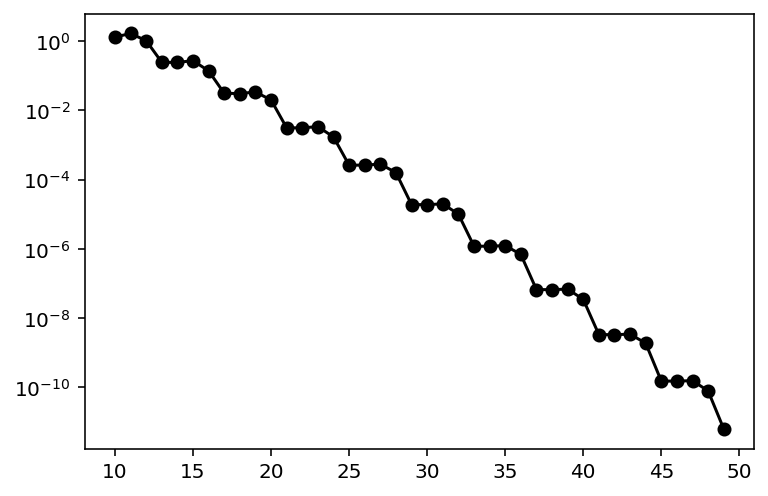

In [24]:
plt.yscale("log")
plt.plot(ns, E, "o-", color="black");

## Shift

In [25]:
f = lambda x, y, z: jnp.cos(jnp.pi*y)*jnp.sin(jnp.pi*z)*jnp.sin(2*jnp.pi*x)
s_f = lambda x, y, z, s: f(x + s[0], y + s[1], z + s[2])

n = 20

x, y, z = Fourier.Uniform_grid(n), Fourier.Uniform_grid(n), Fourier.Uniform_grid(n)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

values = jnp.expand_dims(f(X, Y, Z), -1)
coeff = Fourier.values_to_coefficients(values)

for i in range(3):
  int_coeff = Fourier.transform_coefficients(coeff, i, "shift", alpha=0.33)
  int_values = Fourier.coefficients_to_values(int_coeff, values.shape)

  s = [0]*3
  s[i] = 0.33
  int_exact = jnp.expand_dims(s_f(X, Y, Z, s), -1)
  error = jnp.linalg.norm((int_values - int_exact).reshape(-1,), ord=jnp.inf)
  print(error)

1.6653345369377348e-15
9.43689570931383e-16
8.326672684688674e-16


# Shift

Another implementation of shift. Can be used when one needs to perform individual shift for each channel. Here is an example:

In [26]:
values = random.normal(random.PRNGKey(21), (11, 22, 13, 21))
alphas = jnp.array([1]*21, dtype="float64")
coeff = Fourier.values_to_coefficients(values)
coeff_shifted = vmap(Fourier.shift, in_axes=(-1, None, 0), out_axes=-1)(coeff, 0, alphas)